In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "7" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
import torch 
torch.cuda.is_available()

True

# Hypothesis Testing Automatically Discovered Circuits

Procedure: 
- Compute prune scores (via attribution patching) 
- Search over different thresholds to find the smallest circuit where the null hypotheis of Equivalence / Dominance cannot be rejected 
- Prune edges from circuit that are not in paths to the output, or in the case of resample ablation cannot be reached from the input
- Test whether each edge in the circuit is minimal 
- Test whether the circuit is complete (by seeing if the null hypothesis on the independence test can be rejected)



#  Minimal Faithful Circuit According to Prune Score Ordering

In [3]:
import os
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import torch
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt

from omegaconf import OmegaConf

from auto_circuit.types import BatchKey, AblationType
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.custom_tqdm import tqdm

from elk_experiments.auto_circuit.auto_circuit_utils import (
    desc_prune_scores, 
    prune_scores_threshold, 
)
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc

from elk_experiments.auto_circuit.hypo_tests.equiv_test import (
    Side,
    get_edge_idx, 
    edges_from_mask,
    equiv_test,
    sweep_search_smallest_equiv,
    plot_num_ablated_C_gt_M, 
    plot_circuit_and_model_scores,
    compute_knees, 
    plot_edge_scores_and_knees,
)
from elk_experiments.auto_circuit.hypo_tests.minimality_test import (
    minimality_test, 
    plot_p_values, 
    plot_edge_k, 
    plot_score_quantiles,
)
from elk_experiments.auto_circuit.hypo_tests.indep_test import independence_test
from elk_experiments.auto_circuit.hypo_tests.utils import (
    get_edge_idx, 
    edges_from_mask, 
    set_score,
    result_to_json
)
from elk_experiments.auto_circuit.node_graph import (
    NodeGraph, 
    SeqNode, 
    NodeIdx,
    SampleType,
    get_node_idx, 
    sample_paths, 
    visualize_graph, 
    edge_in_path
)
from elk_experiments.auto_circuit.tasks import TASK_DICT
from elk_experiments.utils import OUTPUT_DIR, repo_path_to_abs_path, load_cache, save_cache, save_json

In [103]:
# config class
@dataclass 
class Config: 
    task: str = "Docstring Token Circuit"
    use_abs: bool = False
    ablation_type: Union[AblationType, str] = AblationType.TOKENWISE_MEAN_CORRUPT 
    grad_func: Optional[Union[GradFunc, str]] = None
    answer_func: Optional[Union[AnswerFunc, str]] = None
    ig_samples: int = 10
    alpha: float = 0.05
    epsilon: Optional[float] = None
    q_star: float = 0.9 
    grad_func_mask: Optional[Union[GradFunc, str]] = None
    answer_func_mask: Optional[Union[AnswerFunc, str]] = None
    clean_corrupt: Optional[str] = None #TODO: make enum
    side: Optional[Union[Side, str]] = None
    max_edges_to_test_in_order: int = 100 #TODO: change to 125
    max_edges_to_sample: int = 100 # TODO: change to 125
    save_cache: bool = True
    
    def __post_init__(self):
        if isinstance(self.ablation_type, str):
            self.ablation_type = AblationType[self.ablation_type.upper()]
        if isinstance(self.grad_func, str):
            self.grad_func = GradFunc[self.grad_func.upper()]
        elif self.grad_func is None:
            self.grad_func = GradFunc.LOGPROB if not self.use_abs else GradFunc.LOGIT
        if isinstance(self.answer_func, str):
            self.answer_func = AnswerFunc[self.answer_func.upper()]
        elif self.answer_func is None:
            self.answer_func = AnswerFunc.AVG_VAL if not self.use_abs else AnswerFunc.AVG_DIFF
        if self.epsilon is None:
            self.epsilon = 0.1 if self.use_abs else 0.0
        if isinstance(self.grad_func_mask, str):
            self.grad_func_mask = GradFunc[self.grad_func_mask.upper()]
        elif self.grad_func_mask is None:
            self.grad_func_mask = self.grad_func
        if isinstance(self.answer_func_mask, str):
            self.answer_func_mask = AnswerFunc[self.answer_func_mask.upper()]
        elif self.answer_func_mask is None:
            self.answer_func_mask = self.answer_func
        if self.clean_corrupt is None:
            self.clean_corrupt = "corrupt" if self.ablation_type == AblationType.RESAMPLE else None
        if isinstance(self.side, str):
            self.side = Side[self.side.upper()]
        if self.side is None:
            self.side = Side.NONE if self.use_abs else Side.LEFT

In [104]:
# initialize config 
conf = Config()
# get config overrides if runnign from command line
if not is_notebook():
    import sys 
    conf_dict = OmegaConf.merge(OmegaConf.structured(conf), OmegaConf.from_cli(sys.argv[1:]))
    conf = Config(**conf_dict)

In [105]:
# handle directories
out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_results")
out_dir.mkdir(exist_ok=True)
score_dir = out_dir / f"{conf.task.replace(' ', '_')}_{conf.ablation_type.name}_{conf.grad_func.name}_{conf.answer_func.name}_{conf.ig_samples}" 
score_dir.mkdir(exist_ok=True)
exp_dir = score_dir / f"{conf.use_abs}_{conf.alpha}_{conf.epsilon}_{conf.q_star}"
if not is_notebook() and exp_dir.exists():
    print(f"Experiment directory {exp_dir} already exists. Exiting.")
    exit()
exp_dir.mkdir(exist_ok=True)

In [106]:
# initialize task
task = TASK_DICT[conf.task]
task.init_task()

In [107]:
# compute edge scores
# TODO: pass full model
prune_scores = mask_gradient_prune_scores(
    model=task.model, 
    dataloader=task.train_loader,
    official_edges=None,
    grad_function=conf.grad_func_mask.value, 
    answer_function=conf.answer_func_mask.value, #answer_function,
    mask_val=None, 
    ablation_type=conf.ablation_type,
    integrated_grad_samples=conf.ig_samples, 
    clean_corrupt=conf.clean_corrupt,
)
if conf.save_cache:
    save_cache(prune_scores, exp_dir, "prune_scores")

Saving cache to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/prune_scores-08-08-2024_16-22-18.pkl


In [108]:
model_out_train: dict[BatchKey, torch.Tensor] = {
    batch.key: task.model(batch.clean)[task.model.out_slice] 
    for batch in task.train_loader
}
model_out_test: dict[BatchKey, torch.Tensor] = {
    batch.key: task.model(batch.clean)[task.model.out_slice] 
    for batch in task.test_loader
}

In [109]:
equiv_results, min_equiv = sweep_search_smallest_equiv(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    grad_function=conf.grad_func, 
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    use_abs=conf.use_abs,
    side=conf.side,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
    model_out=model_out_train,
)
save_json({k: result_to_json(v) for k, v in equiv_results.items()}, exp_dir, "equiv_results")

interval: 0 - 38430
width 1000


interval: 0 - 1000
width 100


interval: 0 - 100
width 10


interval: 20 - 30
width 1


Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/equiv_results.json


In [110]:
equiv_test_result = equiv_test(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    grad_function=conf.grad_func, 
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    edge_counts=[min_equiv],
    use_abs=conf.use_abs,
    side=conf.side,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
    model_out=model_out_test
)[min_equiv]
save_json(result_to_json(equiv_test_result), exp_dir, "equiv_test_result")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/equiv_test_result.json


In [111]:
threshold = prune_scores_threshold(prune_scores, min_equiv, use_abs=conf.use_abs)
edge_mask = {k: (torch.abs(v) if conf.use_abs else v) >= threshold for k, v in prune_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, token=task.token_circuit)
save_json([edge.name for edge in edges], exp_dir, "edges")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/edges.json


In [112]:
# contruct a graph from the pruned circuit, to further prune
node_circ_graph = NodeGraph(edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
node_circ_graph.build_graph()
assert set(node_circ_graph.parents.keys()) == set([k for k in node_circ_graph.children.keys() if k.name != "Resid Start"])

In [134]:
valid_edges = [
    edge for edge in edges 
    if edge_in_path(
        edge, 
        node_circ_graph, 
        reach_req=conf.ablation_type == AblationType.RESAMPLE, # only works for sample b/c E[f(X)] != f(E[X])
        in_path_req=True
    )
]
min_equiv_valid_edges = len(valid_edges)
#save_json([edge.name for edge in valid_edges], exp_dir, "valid_edges")
# mask out all edges not in edges to dest
# edge_score_mask = {k: ((torch.abs(v) if conf.use_abs else v) >= threshold).to(torch.int) for k, v in prune_scores.items()}
invalid_edge_score_mask = task.model.circuit_prune_scores(set(edges) - set(valid_edges)) # edges to remove
valid_edge_scores = {k: prune_scores[k] * (1-invalid_edge_score_mask[k]) for k in prune_scores.keys()}
assert sum([torch.sum(((torch.abs(v) if conf.use_abs else v) >= threshold) & (v != 0)) for v in valid_edge_scores.values()]) == len(valid_edges)

In [114]:
# from elk_experiments.auto_circuit.circuit_hypotests import equiv_test
# recompute equivalence 
valid_edges_equiv_result = equiv_test(
    task.model, 
    task.train_loader,
    valid_edge_scores,
    conf.grad_func,
    conf.answer_func,
    conf.ablation_type,
    edge_counts=[min_equiv_valid_edges],
    model_out=model_out_train,
    full_model=None,
    use_abs=conf.use_abs,
    side=conf.side,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)[min_equiv_valid_edges]
save_json(result_to_json(valid_edges_equiv_result), exp_dir, "valid_edges_equiv_result")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/valid_edges_equiv_result.json


In [135]:
# set cicuit under test
if valid_edges_equiv_result.not_equiv:
    edges_under_test = edges 
    circuit_prune_scores = prune_scores
else: 
    edges_under_test = valid_edges
    circuit_prune_scores = valid_edge_scores
edges_under_test_scores = {edge: prune_scores[edge.dest.module_name][get_edge_idx(edge, tokens=task.token_circuit)] for edge in edges_under_test}
edges_under_test = sorted(edges_under_test_scores.keys(), key=lambda x: abs(edges_under_test_scores[x]), reverse=False)

In [136]:
fig = draw_seq_graph(
    model=task.model,
    prune_scores=circuit_prune_scores,
    score_threshold=threshold,
    show_all_seq_pos=True,
    orientation="h",
    use_abs=conf.use_abs,
    display_ipython=is_notebook(),
    seq_labels=task.test_loader.seq_labels,
)
fig.write_image(repo_path_to_abs_path(exp_dir / "valid_edge_graph.png"))

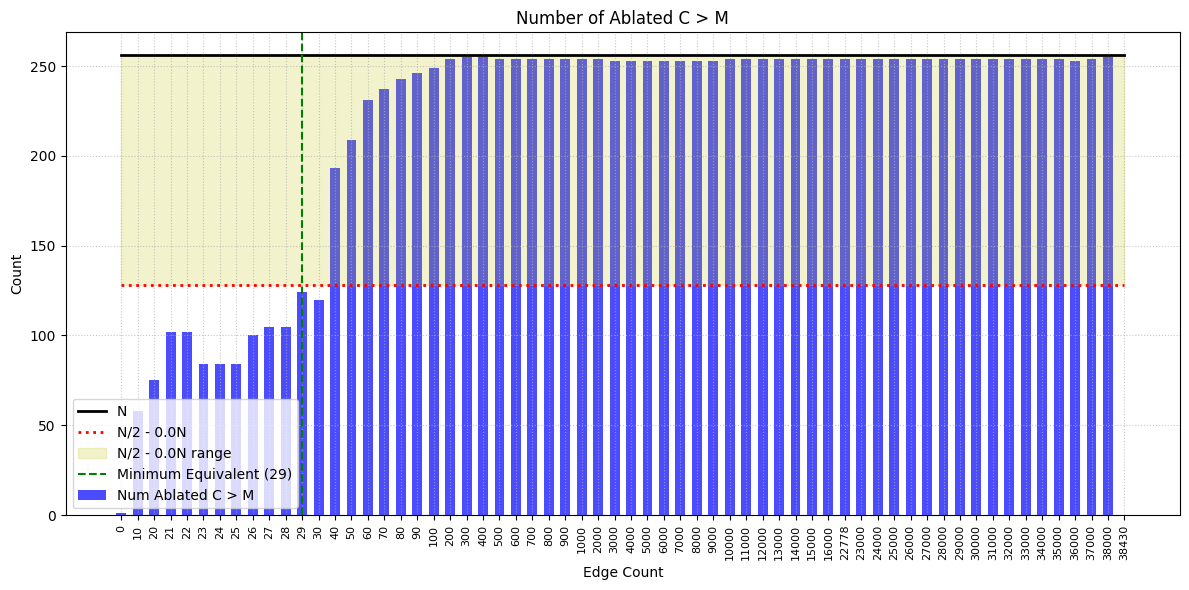

In [19]:
fig, ax = plot_num_ablated_C_gt_M(equiv_results, epsilon=conf.epsilon, min_equiv=min_equiv, side=conf.side)
fig.savefig(repo_path_to_abs_path(exp_dir / "num_ablated_C_gt_M.png"))

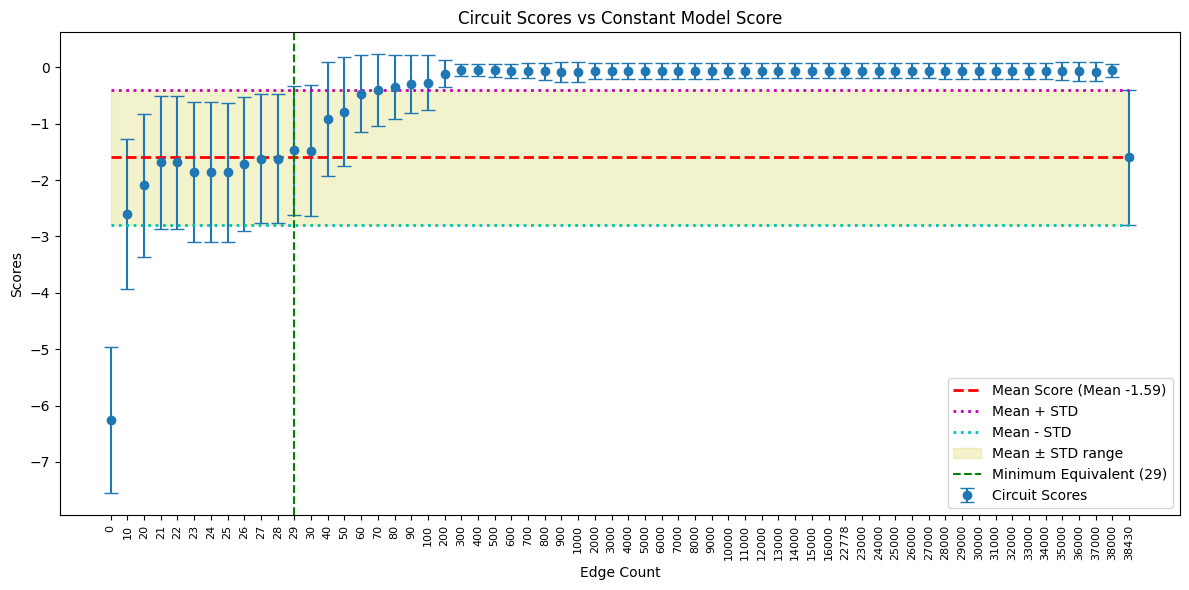

In [20]:
fig, ax = plot_circuit_and_model_scores(equiv_results, min_equiv)
fig.savefig(repo_path_to_abs_path(exp_dir / "circuit_model_scores.png"))

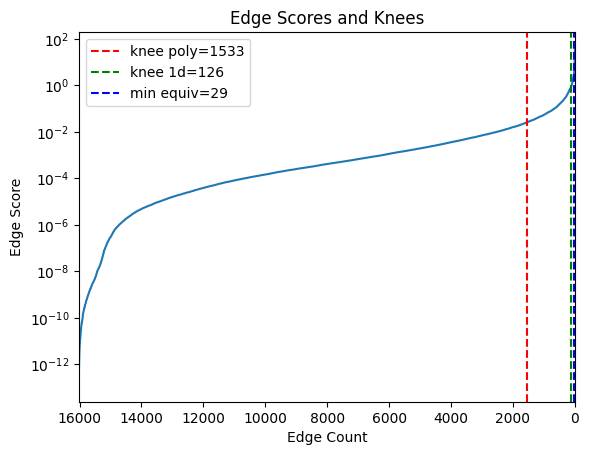

In [26]:
# plot attribution scores 
import numpy as np
edge_scores = np.flip(desc_prune_scores(prune_scores, use_abs=conf.use_abs).detach().cpu().numpy())
if not conf.use_abs:
    edge_scores = edge_scores[edge_scores > 0]
kneedle_poly, kneedle_1d = compute_knees(edge_scores)
fig, ax = plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv)
fig.savefig(repo_path_to_abs_path(exp_dir / "edge_scores_knees.png"))

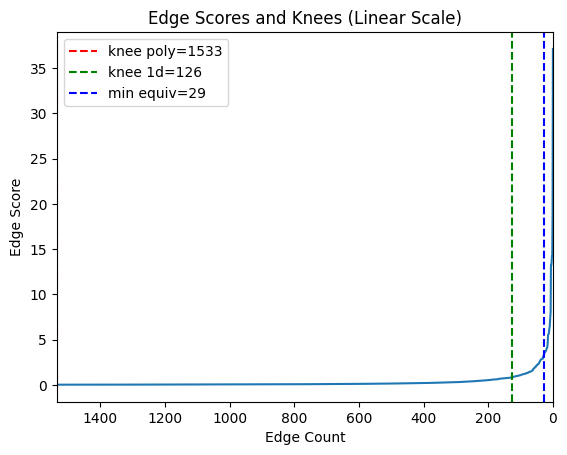

In [28]:
# zoom in to attribution scores
ax.set_xlim(len(edge_scores) - kneedle_poly.knee + 1,)
ax.set_yscale('linear')
ax.set_title("Edge Scores and Knees (Linear Scale)")
fig.savefig(repo_path_to_abs_path(exp_dir / "edge_scores_knees_linear.png"))
fig

# Minimality Test

In [137]:
# build full grap to sample paths
node_graph = NodeGraph(task.model.edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
node_graph.build_graph()

In [138]:
# sample paths to be used for testing
n_paths = 256 
filtered_paths_walk = sample_paths(node_graph, n_paths, SampleType.WALK, edges_under_test)
mean_walk = np.mean([len(path) for path in filtered_paths_walk])
filtered_paths_uniform = sample_paths(node_graph, n_paths, SampleType.UNIFORM, edges_under_test)
mean_uniform = np.mean([len(path) for path in filtered_paths_uniform])
mean_walk, mean_uniform

(np.float64(3.21875), np.float64(4.93359375))

In [139]:
# run minimality test
min_test_results, min_test_sampled_results = minimality_test(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=circuit_prune_scores,
    edges=edges_under_test, 
    edge_count=len(edges_under_test),
    ablation_type=conf.ablation_type,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    filtered_paths=filtered_paths_walk,
    use_abs=conf.use_abs,
    tokens=task.token_circuit,
    alpha=conf.alpha, 
    q_star=conf.q_star, 
    max_edges_in_order=conf.max_edges_to_test_in_order,
    max_edges_to_sample=conf.max_edges_to_sample,
)
save_json({e.name: result_to_json(r) for e, r in min_test_results.items()}, exp_dir, "min_test_results")
save_json({e.name: result_to_json(r) for e, r in min_test_sampled_results.items()}, exp_dir, "min_test_sampled_results")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/min_test_results.json
Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/min_test_sampled_results.json


In [141]:
# minimality test on true edges
min_postfix = f"{conf.q_star}_{conf.alpha}"
min_postfix_full = f"{conf.max_edges_to_test_in_order}_{min_postfix}"
# check if already tested 
true_edges_tested = (score_dir / f"min_test_true_edge_results_{min_postfix_full}.json").exists() and not is_notebook()

if not true_edges_tested:
    true_edge_prune_scores = task.model.circuit_prune_scores(task.true_edges)
    filtered_paths_true_edge = sample_paths(node_graph, n_paths, SampleType.WALK, task.true_edges)
    min_test_true_edge_results, min_test_true_edge_sampled_results = minimality_test(
        model=task.model, 
        dataloader=task.test_loader,
        prune_scores=true_edge_prune_scores,
        edges=list(task.true_edges), 
        edge_count=task.true_edge_count,
        ablation_type=conf.ablation_type,
        grad_function=conf.grad_func,
        answer_function=conf.answer_func,
        filtered_paths=filtered_paths_true_edge,
        use_abs=conf.use_abs,
        tokens=task.token_circuit,
        alpha=conf.alpha, 
        q_star=conf.q_star,
        stop_if_failed=False, 
        max_edges_in_order=conf.max_edges_to_test_in_order,
        max_edges_to_sample=conf.max_edges_to_sample,
    )
    save_json({e.name: result_to_json(r) for e, r in min_test_true_edge_results.items()}, score_dir, f"min_test_true_edge_results_{min_postfix_full}")
    save_json({e.name: result_to_json(r) for e, r in min_test_true_edge_sampled_results.items()}, score_dir, f"min_test_true_edge_sampled_results_{conf.max_edges_to_sample}_{min_postfix}")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/min_test_true_edge_results.json
Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/min_test_true_edge_sampled_results.json


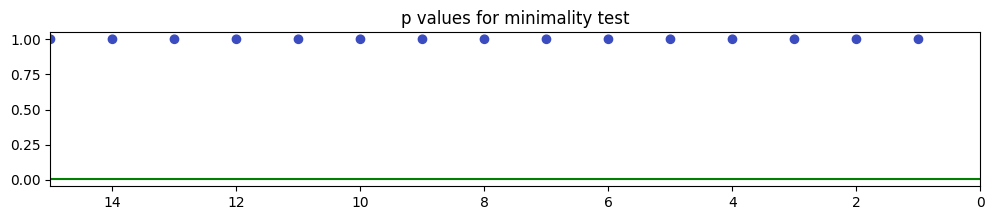

In [142]:
# plot p values``
fig, ax = plot_p_values(min_test_results, edges_under_test_scores, alpha=conf.alpha / len(edges_under_test))
fig.savefig(repo_path_to_abs_path(exp_dir / "min_test_p_values.png"))


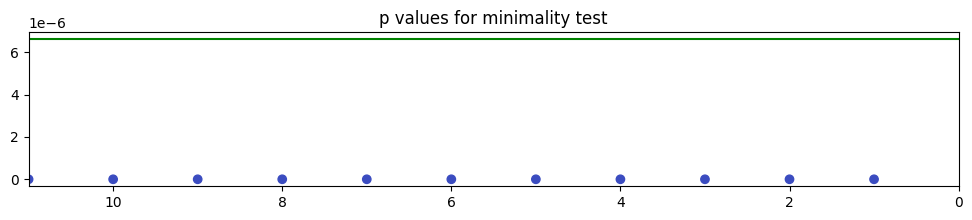

In [143]:
if not true_edges_tested:
    true_edge_scores = {edge: torch.tensor(1.0) for edge in task.true_edges} # don't actually know
    fig, ax = plot_p_values(min_test_true_edge_results, true_edge_scores, alpha=conf.alpha / task.true_edge_count)
    fig.savefig(repo_path_to_abs_path(score_dir / f"min_test_true_edge_p_values_{min_postfix_full}.png"))

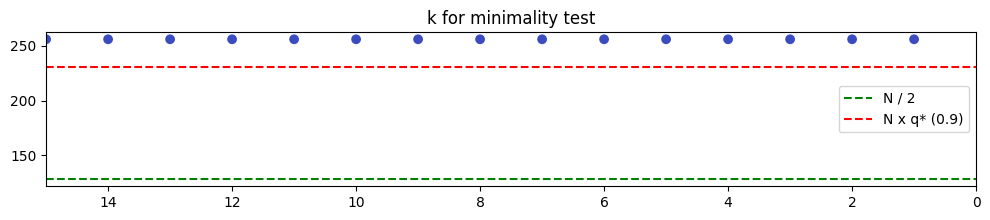

In [144]:
# plot frac of n 
batch_size = task.batch_size[1] if isinstance(task.batch_size, tuple) else task.batch_size
batch_count = task.batch_count[1] if isinstance(task.batch_count, tuple) else task.batch_count
fig, ax = plot_edge_k(min_test_results, edges_under_test_scores, batch_size * batch_count, q_star=conf.q_star)
fig.savefig(repo_path_to_abs_path(exp_dir / "min_test_edge_k.png"))

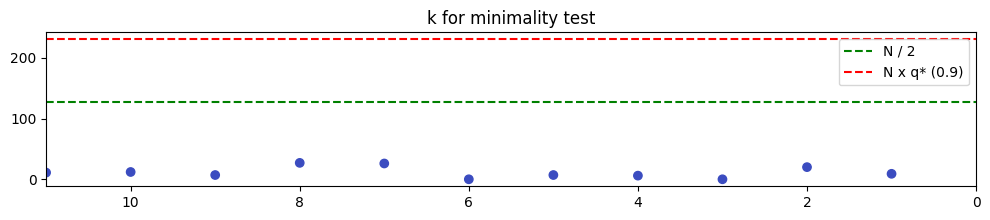

In [145]:
if not true_edges_tested:
    batch_size = task.batch_size[1] if isinstance(task.batch_size, tuple) else task.batch_size
    batch_count = task.batch_count[1] if isinstance(task.batch_count, tuple) else task.batch_count
    fig, ax = plot_edge_k(min_test_true_edge_results, true_edge_scores, batch_size * batch_count, q_star=conf.q_star)
    fig.savefig(repo_path_to_abs_path(score_dir / f"min_test_true_edge_k_{min_postfix_full}.png"))

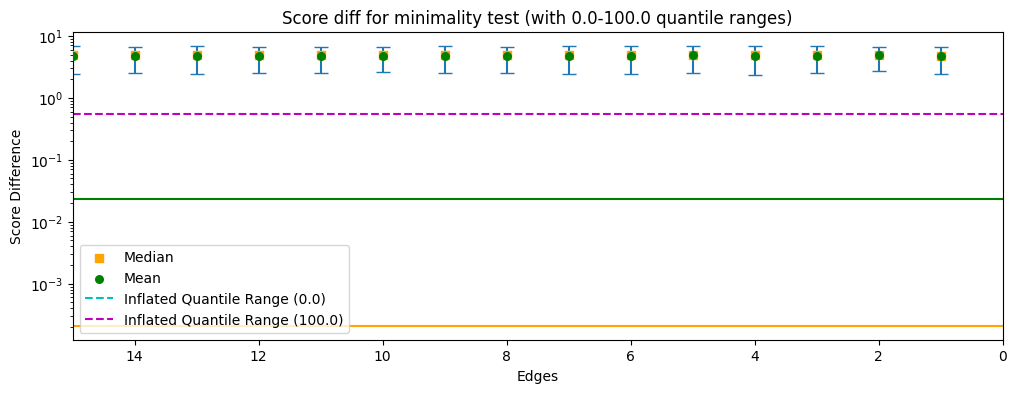

In [146]:
# plot average diff 
fig, ax = plot_score_quantiles(min_test_results, edges_under_test_scores, quantile_range=[0.00, 1.00])
fig.savefig(repo_path_to_abs_path(exp_dir / f"min_test_score_quantiles.png"))


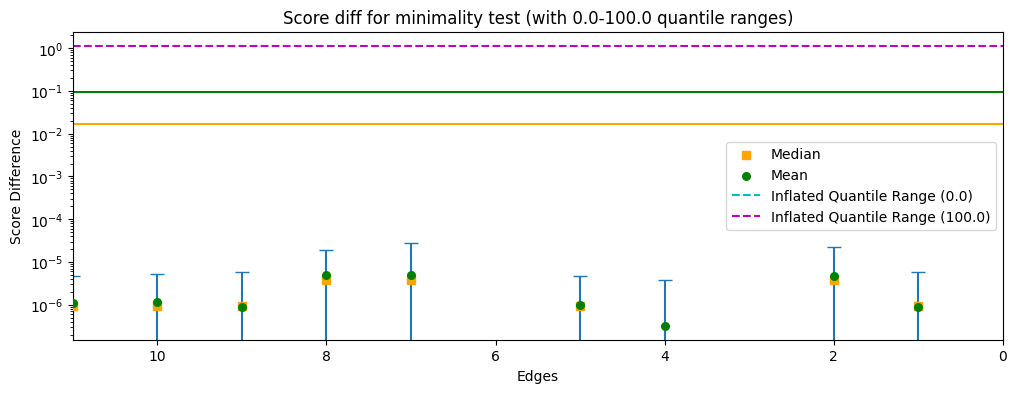

In [147]:
if not true_edges_tested:
    fig, ax = plot_score_quantiles(min_test_true_edge_results, true_edge_scores, quantile_range=[0.00, 1.00])
    fig.savefig(repo_path_to_abs_path(score_dir / f"min_test_true_edge_score_quantiles_{min_postfix_full}.png"))

# Independence Test
Test for completeness - if the circuit contains all the components required to perform the task, then the output of the complement should be independent of the original model

$H_0$: Score of complement indepedendent of score of model

Hilbert Schmdit Indepednence Criterion - non-parametric measure of independence 

- Background: (see https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/)

Intuition: the trace sums along the interaction terms on each data point, which 
we expect to be larger then other interaction terms across samples if X, and Y are 
correlated, fewer of the perumations should be greater, our p-value will be smaller, 
and thus we're more likely to reject the null


Note: the hypothesis paper defines HCIC as  K_{x,y}K_{x,y}, but can also define it as 
{K_x}{K_y}, b/c that that equality holds in general for Cross Covariance and Auto 
Covariance 

The paper uses $\rho$ = median(||score(complement) - score(model)||), based on this 
paper https://arxiv.org/pdf/1707.07269




In [148]:
indep_result = independence_test(
    model=task.model, 
    dataloader=task.test_loader, 
    prune_scores=circuit_prune_scores, 
    ablation_type=conf.ablation_type,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    threshold=threshold, 
    use_abs=conf.use_abs,
    B=1000
) 
save_json(result_to_json(indep_result), exp_dir, "indep_result")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/indep_result.json


In [149]:
indep_true_edge_result = independence_test(
    task.model, 
    task.test_loader, 
    true_edge_prune_scores, 
    ablation_type=conf.ablation_type,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    threshold=1.0, 
    use_abs=True,
    alpha=conf.alpha,
    B=1000
)
save_json(result_to_json(indep_true_edge_result), score_dir, f"indep_true_edge_result")

Saving json to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Docstring_Token_Circuit_TOKENWISE_MEAN_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_0.0_0.9/indep_true_edge_result.json
